# 生存分析を利用したワランティ発生数予測

今週と来週は、生存分析を使用してワランティ発生数を予測する。

今回はSQLのクエリが頻出する。分析を主眼としたクエリについては、例えば["ビッグデータ分析・活用のためのSQLレシピ"](https://www.amazon.co.jp/dp/B06XRWPPC9/ref=cm_sw_em_r_mt_dp_U_HPOwDb913Z6EE)が詳しい。

## 生存時間分析概論

### 特徴

- 生存時間分析(**Survival analysis**)とは、「ある時点から何らかのイベントが発生する時点までの時間」を対象とした統計分析及びそのための手法である。  
- **Time-to-Event分析(Time-to-Event analysis)**とも呼ばれる。  
- その名のとおり、医療分野における死亡までの時間の分析の他、機械の使用開始から最初の故障が発生するまでの時間や、ある顧客が有料会員になってから退会するまでの期間の分析など、「何らかのイベントが発生するまでの時間」や「一定期間における、次のイベント発生の確率」を分析する際に、分野問わず幅広く使用されている。

- 実問題に適用する際の注意点としては、
    - 既存の生存時間分析の枠組みは、**「説明変数(外生変数)の時間変化がない」**あるいは**「ごく簡単な時間変化」**(線形に増加するなど)が前提とされていることが多い。(比較的最近に提案された機械学習系の生存時間分析の一部は、その限りではないが...)
        - 例えば、ある機械の故障までの生存期間を分析する際に、外部温度を説明変数として取り込みたいとする。この場合は、外部温度は上がったり下がったりするが、説明変数としては、"生存期間の平均外部温度","生存期間の最高外部温度"のように、1つの値として入力する必要がある。よって、時系列変化を取り込みにくい。
    - Time-to-Eventの名のとおり、**次のイベントまで**を対象とする分析である。
        - 例えば今回のワランティ数分析では、同一の車が何度かワランティを申請/処理することがあるが、その場合は"販売->1回目の故障", "1回目の故障->2回目の故障",..., とそれぞれの生存期間サンプルに分けてから、分析を行う必要がある。

- 生存時間分析に特有の概念として、**打ち切り**の存在がある。例えば、今回の例であれば、多くの車は一度も故障せずにデータ収集最終日を迎える廃車を迎えると考えられる。また、死亡時点までの分析であれば、多くの患者は実験最終日まで生存していたり、退院してデータが取れなくなったりするだろう。そのような、イベントを迎えずに期間が終了することを**打ち切り**(または右側打ち切り)と呼ぶ。

### 生存時間分析の流れ

生存時間分析は、一般に次のような手順で行われる。

1. データから各サンプルの生存期間を算出する。終わりが打ち切りであったかどうか、分かるようにしておく。
2. 各サンプルの生存期間と打ち切りの有無から、**生存関数**を推定する。
    - 関数の推定方法としては、**カプラン・マイヤー推定**と**アーレン・ネルソン推定**があるが、おおよそ両者は似たような結果になる。
3. 推定された生存関数をモデルによって近似する。近似方法によって、大まかに以下の4種類に分けられる
    - **ノンパラメトリックモデル**(得られた生存関数をそのまま使う)
    - **セミパラメトリックモデル**(Cox比例ハザードモデルなど)
    - **パラメトリックモデル**(ワイブル分布モデル、指数分布モデルなど)
    - **機械学習モデル**(ランダムサバイバルフォレストなど)
4. モデルを用いて予測を行ったり、モデルを用いて説明変数の影響を検定にかけたりする(投薬の効果の有無など)

#### モデルについて補足

- ノンパラメトリックモデルは、説明変数(外生変数)を持たない。カプラン・マイヤーなどで推測された関数をそのまま用いる方法である。
- セミパラメトリック、パラメトリック、機械学習モデルは、説明変数を持つ。ただし、多くの場合、説明変数は生存期間中に時間変化しないことを前提とする。
- セミパラメトリック、パラメトリックモデルは、比例ハザード性を仮定することが多い。これはどういうことかというと、「外生変数Aが〇〇だった場合(カテゴリ変数の場合)or大きくなるにつれて(連続変数の場合)、各時点の死亡確率が一律XX倍に上昇/下落する」というような仮定である。
- セミパラメトリックモデルは、比例ハザード性とノンパラメトリックを組み合わせたモデルである。何らかのベースラインとなる生存関数を仮定して、説明変数によって、一律に死亡確率が上がったり下がったりするようなモデルである。ベースラインの関数系は特に仮定しないので、柔軟な分、サンプル数が少ない場合は推定誤差も増える。
- パラメトリックモデルは、生存関数が完全に時間と説明変数のみをパラメータとする数式として書ける、と仮定するモデルである。例えば指数分布などがよく用いられる。
- 一部の機械学習モデルは、時間変化する外生変数を取り込むことのできるモデルも存在する。ランダムサバイバルフォレストなど、2000年代後半から提案された、比較的新しいものが多い。
- 今回のケースでの説明変数は、モデルの種類、過去の故障の有無(初めてか、再発か)などが考えられる。

### 生存時間分析のExcelでの例

Excel sheet"20190821_survival_analysis.xlsx"を参照

### (Optional)生存時間分析における数式

ある時点$t$までに死亡している確率$F(t)$は、以下のような、分布関数で与えられる。
$$F(t) = P(u < t) = \int_0^t f(u)du$$

ある時点tにまだ生きている確率$S(t)$は、時点tにまだ死亡していない確率なので、
$$S(t) = 1-F(t)$$

この確率$S(t)$を、$t$の関数とみなし、**生存関数**と呼ぶ。

ある時点tまで生きていて、その後、時間$\delta t$後までに死ぬ確率を時間$\delta t$で割った値、$h(t)$を考える。すなわち、
$$h(t) = \lim_{\delta t \to 0} \left\{\frac{P(t \leq T < t + \delta t | T \geq t)}{\delta t} \right\}$$
これは、死亡確率の強度や密度のように考えることができる。  
$h(t)$に期間$u$をかけた値$h(t)u$は、$u$が小さければ、その期間の死亡確率ととらえることができる。

式変形から、
$$h(t) = - \frac{d}{dt}\left(log S(t)\right)$$
となることが示せる(式変形の過程は省略)。

また、
$$H(t) = \int_0^t h(u)du$$
とおくと、
$$S(t) = exp\left(-H(t)\right)$$
となることが示せる(式変形の過程は省略)。

結果、$H(t)$は
$$H(t) = -logS(t)$$
とも書ける。

※今回省略した式変形については[英語版Wikipedia](https://en.wikipedia.org/wiki/Survival_analysis)に掲載がある。生存分析の教科書としては、[医薬統計のための生存時間データ解析](https://www.amazon.co.jp/dp/4320110358/ref=cm_sw_em_r_mt_dp_U_ye.wDb4BDF7AY)や、[生存時間解析入門](https://www.amazon.co.jp/dp/4130623125/ref=cm_sw_em_r_mt_dp_U_Ye.wDbCMDQF9K)がわかりやすい。

## 今回のケース(ワランティ数の予測)への生存分析の適用の方針

0. データを訓練データとバリデーションデータとテストデータに分割する。今回は、一旦、訓練データを2013年12月31日まで、バリデーションデータを2014年1月1日~2014年12月31日、テストデータを2015年1月1日以降とした。
1. 各パーツについて、購入から故障、または交換から故障までの期間の生存期間データを集計する
2. 生存関数をモデリングする。
3. 生存関数モデルによって、稼働中の全車両の当該パーツについて、故障までの予測期間、及び予想故障月(予測時点+故障までの予測期間)を計算する。
4. 得られた故障予測月データから、各月の予測故障件数を集計する。

## データからの生存期間の算出と集計

まず、データから各パーツの生存期間を算出する。今回のケースでは、生存期間は以下のように分類できる。

![生存期間の分類の図](figures/type_survival_term.jpg)

タイプ1とタイプ2~4で、分けてテーブルを作成、集計する。

### (Optional)PostgreSQLとPython

今回はSQLiteで実行すると遅い & 使用できない関数があったので、PostgreSQLを使用して分析した。  
Suzuki様環境からのTeradataへのアクセス環境が整い次第、Teradataに移行予定であるが、経過措置としてPostgreSQLを利用する。

また、PostgreSQLはMacBookに容易にローカル環境でセットアップすることが可能である。

[こちら](https://qiita.com/mochizukikotaro/items/84204d5c46b67c9b74f4)を参考に、以下の手順で環境をセットアップする。

1. `brew install postgresql`  でHomebrewを使ってインストール  
2. `postgres --version`　でインストールされていることを確認  
3. `postgres -D /usr/local/var/postgres`  でサーバー起動。デフォルト設定では、localhost(127.0.0.1)のポート5432でアクセスができる。  
4. 別ターミナルを開き、`psql -l`  でデータベース一覧を確認。もし新たにデータベースを作成する場合は、`createdb hogehoge`のように作成。  
5. `psql -d hogehoge`でローカルのデータベースhogehogeにログイン。`psql -p 5432 -h localhost -d hogehoge`と明示してもよい。
6. サーバーを起動したターミナルで<kbd>Ctrl + d</kbd>でサーバーを停止できる

Python側もセットアップする必要がある。今回はpsycopg2というライブラリを使用する。`conda install psycopg2 `でインストールする。

インストール後、以下のようにして、接続インスタンスを生成する。

In [1]:
import psycopg2
from psycopg2.extras import DictCursor
import pandas as pd

In [25]:
# formatは'postgresql://{ユーザー}:{パスワード}@{ホスト}:{ポート}/{データベース}'
# 眞田環境ではユーザーもパスワードも特に設定せずデフォルトのままなので、それらを省略し、以下のようにして生成
# 裏側でsqlalchemyが勝手にpsycopg2を呼び出してくれる
con = psycopg2.connect('postgresql://:@localhost:5432/suzuki_phase2')

In [29]:
# 結果をpandas dataframeで取得するための関数をつくっておく
def createDFfromquery(query, con):
    with con.cursor(cursor_factory=DictCursor) as cur:
        try:
            cur.execute(query)
            rows = cur.fetchall()
            df = pd.DataFrame([dict(row) for row in rows])
            return df
        except:
            con.rollback()
            raise

In [32]:
with pd.option_context("display.max_columns", 1000):
    display(createDFfromquery("select * from warranty limit 2", con))

,w_base_cd,w_causal_part_no,w_cfc_amt,w_cfc_company_cd,w_cfc_rate,w_crt_time_stamp,w_dist_cd,w_dist_country_cd,w_dist_issue_no,w_div1,w_div2,w_div3,w_dmex_div,w_dtc_1,w_dtc_2,w_failure_date,w_fc_to_failure,w_fcok,w_field_claim_div,w_fixed_div,w_key,w_labor_amt,w_labor_hour,w_mileage,w_mileage_div,w_minus_div,w_operation_cd,w_parts_amt,w_process_month,w_prod_base_cd,w_prod_div,w_prod_model_cd,w_sales_date,w_sales_to_failure,w_sb_no,w_shipping_amt,w_shop_cd,w_shop_div,w_src_div,w_src_key,w_sublet_amt,w_sublet_hour,w_total_amt,w_trouble_cc,w_trouble_cp,w_trouble_df,w_trouble_mp,w_vin
0,100100,32140-35410,217.00,3149,13,2017-06-16 07:53:47.729630,4992A,PK,9704034,None,0,0,1,None,None,19970305,11,19960401,1,1,WRPKJP199705A000034,325.00,0.5,2100,K,1,EB9999,708.00,199705,100100,A,X3427,19960715,8,None,757.00,None,1,1,1997054992A9704034,0.00,0.0,1790.00,None,01,37,None,A80-PK106054
1,100100,32140-35410,217.00,3149,13,2017-06-16 07:53:47.731448,4992A,PK,9704053,None,0,0,1,None,None,19970226,8,19960601,1,1,WRPKJP199705A000035,325.00,0.5,0,K,1,EB9999,708.00,199705,100100,A,X3427,19970226,0,None,757.00,None,1,1,1997054992A9704053,0.00,0.0,1790.00,None,01,37,None,A80-PK106383


In [33]:
# 結果を取得しないタイプの関数も作っておく
def executequery(query, con):
    with con.cursor() as cur:
        try:
            cur.execute(query)
        except:
            con.rollback()
            raise

### データクレンジング

変な日付が混ざっているので、それらを含むレコードを除去する。

#### W_FAILURE_DATE列

In [5]:
df_w_failure_date_distinct = createDFfromquery("""
    select distinct(w_failure_date) from warranty order by w_failure_date""",
                                              con)

In [6]:
df_w_failure_date_distinct["is_error"] = (pd.to_datetime(
    df_w_failure_date_distinct.w_failure_date, errors="coerce").isna())

In [7]:
w_failure_date_error_list = (df_w_failure_date_distinct
                             .loc[df_w_failure_date_distinct.is_error, "w_failure_date"]
                             .to_list())
w_failure_date_error_list[:5]

['00000000', '000001', '000003', '000008', '000009']

In [8]:
error_list_str = ",".join(["'{}'".format(c) for c in w_failure_date_error_list])

In [9]:
df_w_failure_date_error = createDFfromquery("""select w_failure_date, count(*) from warranty
where w_failure_date in
({error_list_str})
group by w_failure_date;""".format(error_list_str = error_list_str), con)

In [212]:
print("""select w_failure_date, count(*) from warranty
where w_failure_date in
({error_list_str})
group by w_failure_date;""".format(error_list_str = error_list_str))

select w_failure_date, count(*) from warranty
where w_failure_date in
('00000000','000001','000003','000008','000009','000010','000011','000012','000013','000014','000015','000016','000017','000018','000019','000020','000021','000022','000024','000026','000027','000028','000030','000032','000050','000052','00230705','01080114','05050720','06122700','10070925','11101108','11101111','12120319','13031900','13040300','19970229','19970230','19970631','20130931')
group by w_failure_date;


In [11]:
df_w_failure_date_error["count"].sum()

16386

16386レコードを除去する。

#### W_SALES_DATE

In [12]:
df_w_sales_date_distinct = createDFfromquery("""
    select distinct(w_sales_date) from warranty order by w_sales_date""",
                                               con)
df_w_sales_date_distinct["is_error"] = (pd.to_datetime(
    df_w_sales_date_distinct.w_sales_date, errors="coerce").isna())
w_sales_date_error_list = (df_w_sales_date_distinct
                             .loc[df_w_sales_date_distinct.is_error, "w_sales_date"]
                             .to_list())
w_sales_date_error_list[:5]

['0', '00000000', '00000020', '02021116', '06090520']

In [13]:
error_list_str_sales = ",".join(["'{}'".format(c) for c in w_sales_date_error_list])
df_w_sales_date_error = createDFfromquery("""select w_sales_date, count(*) from warranty
where w_sales_date in
({error_list_str_sales})
group by w_sales_date;""".format(error_list_str_sales = error_list_str_sales), 
                                          con)
df_w_sales_date_error.head()

,count,w_sales_date
0,133,0
1,94034,00000000
2,2,00000020
3,1,02021116
4,1,06090520


In [14]:
df_w_sales_date_error["count"].sum()

94330

94330レコードを除去する

#### V_FCOK

In [15]:
df_v_fcok_distinct = createDFfromquery("""
    select distinct(v_fcok) from fcok order by v_fcok""",con)
df_v_fcok_distinct["is_error"] = (pd.to_datetime(
    df_v_fcok_distinct.v_fcok, errors="coerce").isna())
v_fcok_error_list = (df_v_fcok_distinct
                             .loc[df_v_fcok_distinct.is_error, "v_fcok"]
                             .to_list())
v_fcok_error_list[:5]

['20000100']

In [16]:
error_list_str_fcok = ",".join(["'{}'".format(c) for c in v_fcok_error_list])
df_v_fcok_error = createDFfromquery("""select v_fcok, count(*) from fcok
where v_fcok in
({error_list_str_fcok})
group by v_fcok;""".format(error_list_str_fcok = error_list_str_fcok), con)
df_v_fcok_error.head()

,count,v_fcok
0,10,20000100


10レコードを除去する

### タイプ1の生存期間データの作成と集計

- 購入から、ワランティが一度も申請されずに訓練データ収集最終日(2013年12月31日)を迎えたパーツについて、生存期間を作成・集計する。
- どのパーツがどの車種に含まれているかは、**全期間の**ワランティデータを車種コード上3桁、パーツコード上5-3桁を用いて集計し、件数が5件以上あった組み合わせについて、そのパーツ(群)はその車種(群)の車に含まれていると判断する。
- 訓練データ期間中のワランティデータに、同一VINで、上5-3桁が同じパーツのワランティレコードが含まれていた場合は、そのVINのそのパーツ(群)は、ワランティ申請歴あり、ということで、集計から除外する。
- 生産記録テーブル(fcokテーブル)については購入日を示す項目が含まれていないため、V_FCOK列(FCOK日)をもって、購入日とみなす。実際にはFCOK日から購入日までは1~3ヶ月程度のラグがあることに留意。
- 後述のタイプ2~4にあわせ、生存期間の精度(粒度)は月単位とする。

**<font color=red>V_SPEC = "000"</font>**

- 各種フィルタリング条件は以下のとおり。
    - 生産テーブル
        - 国内拠点生産(V_BASE_CD = '100100')
        - 四輪(V_PROD_DIV = 'B')
    - ワランティテーブル
        - 国内向け出荷分(W_DMEX_DIV = '0')
        - 国内拠点生産(W_PROD_BASE_CD = '100100')
        - 国内拠点処理(W_BASE_CD = '100100')
        - 四輪(W_PROD_DIV = 'B')

#### パーツ-モデルの多対多関係を示す中間テーブルの作成

In [214]:
cutoff_n_master = 5 # そのパーツ-モデルの組み合わせのワランティデータが5件以上ある場合は、マスターに登録

In [47]:
sql_master = """
select 
    substr(w_causal_part_no, 1, 9) as causal_part
    ,substr(w_prod_model_cd, 1, 3) as model_code
    ,count(*) as n
from warranty
where 
    W_SALES_DATE not in ({error_list_str_sales})
    and W_FAILURE_DATE not in ({error_list_str})
    and W_PROD_BASE_CD = '100100'
    and W_BASE_CD = '100100'
    and W_PROD_DIV = 'B'
    and W_DMEX_DIV = '0'
    and w_prod_model_cd is not null
group by causal_part, model_code
having count(*) >= {cutoff_n_master};
""".format(error_list_str_sales=error_list_str_sales, 
           error_list_str=error_list_str,
           cutoff_n_master=cutoff_n_master)

In [48]:
%%time
df_part_model_master = createDFfromquery(sql_master, con)

CPU times: user 228 ms, sys: 17.3 ms, total: 246 ms
Wall time: 17 s


In [216]:
df_part_model_master.head(30)

,causal_part,model_code,n
0,*1150-JB2,YR6,16
1,*1150-MC1,YJ0,8
2,*1150-MC2,YJ0,14
3,*2271-CT5,YC0,10
4,*2271-CV5,YC0,6
5,*2271-DA5,YH5,6
6,*2271-MC1,YJ0,6
7,*2271-MC2,YJ0,21
8,*2400-DB5,YH5,5
9,*2470-CT5,YC0,9


In [51]:
# 一時テーブルに保存しておく
executequery("create temp table part_model_master as " + sql_master, con)

#### 集計を実行

In [41]:
# 今回対象とするパーツ群
selected_part_TD = ["27610-76G", "37950-58J", "95411-82K", 
                    "09283-350", "33920-77F", "33220-76G", "55311-75F",
                    "55311-72J", "53200-58J", "84702-70K"]
target_parts_str = ",".join(["'{}'".format(part) for part in selected_part_TD])

cutoff_date = '2014-01-01' # 訓練データ最終日 + 1

In [45]:
sql_term_type1 = """
-- 生産テーブルから必要なデータを抽出し、FCOKを月単位にならす
with t_fcok as (
    select 
        to_date(substr(v_fcok, 1, 6), 'YYYYMM') as fcok_month
        ,substr(v_prod_model_cd, 1, 3) as model_code
        ,v_vin
    from fcok
    where v_base_cd = '100100'
        and v_prod_div = 'B'
        and v_fcok not in ('20000100')
        and v_fcok < '{cutoff_date}'
)

-- ワランティテーブルから必要なデータを抽出し、パーツ番号を上5-3桁に切り取り、(VIN-パーツ番号)がユニークになるように
, t_warranty as (
    select 
        substr(w_causal_part_no, 1, 9) as causal_part
        ,w_vin
    from warranty
    where 
        W_SALES_DATE not in ({error_list_str_sales})
        and W_FAILURE_DATE not in ({error_list_str})
        and W_PROD_BASE_CD = '100100'
        and W_BASE_CD = '100100'
        and W_PROD_DIV = 'B'
        and W_DMEX_DIV = '0'
        and to_date(w_process_month,'YYYYMM') < '{cutoff_date}'
    group by w_vin, causal_part
)

-- 抽出した生産テーブルとパーツ-モデルマスタデータから、対象パーツについて、生産された全パーツのテーブルを作成。生存期間も計算。
, term_all as (
    select
        t_fcok.model_code
        ,causal_part
        ,extract(year from age('{cutoff_date}', fcok_month))*12
                + extract(month from age('{cutoff_date}', fcok_month)) as month_passed
        ,v_vin || causal_part as vin_part
    from t_fcok
    join part_model_master as pm_master
        on pm_master.model_code = t_fcok.model_code
    where pm_master.causal_part in ({target_parts_str})
)

-- ワランティデータに出現したVIN-パーツのペアは除外したのち、パーツxモデルx生存期間毎にパーツ数を集計する
select
    model_code
    ,causal_part
    ,month_passed
    ,count(*) as sample_count
from term_all
where term_all.vin_part not in (
    select w_vin || causal_part from t_warranty
    where causal_part in ({target_parts_str})
    )
group by model_code, causal_part, month_passed
;""".format(cutoff_date=cutoff_date, error_list_str=error_list_str,
            error_list_str_sales=error_list_str_sales,
            target_parts_str=target_parts_str)

In [52]:
%%time
df_term_type1 = createDFfromquery(sql_term_type1, con)

CPU times: user 121 ms, sys: 18.9 ms, total: 140 ms
Wall time: 3min 45s


In [218]:
df_term_type1.shape

(9389, 4)

In [219]:
df_term_type1.head()

,causal_part,model_code,month_passed,sample_count
0,09283-350,Y1J,1.0,5699
1,09283-350,Y1J,2.0,5963
2,09283-350,Y1J,3.0,5948
3,09283-350,Y1J,4.0,5527
4,09283-350,Y1J,5.0,5311


### タイプ2~4の生存期間データの作成と集計

- 以下のパターンのパーツについて、生存期間を作成・集計する。
    - 2.購入から初回故障
    - 3.前回交換から今回故障
    - 4.前回交換から故障せずに訓練データ集計最終日(2013年12月31日)を迎える
- 交換は、ワランティテーブルのW_PROCESS_MONTHの月に交換作業があったとみなす。したがって、生存期間の精度(粒度)は月単位となる。
- 交換および故障は、主原因品番(W_CAUSAL_PART_NO)のパーツのみが故障し、交換されたとみなす。実際には、その他のパーツも故障・交換されている可能性が高いことに留意。
- 同じパーツが過去に交換されたか否かは、VINとパーツコード(全桁)と交換日(W_PROCESS_MONTH)と故障日(W_FAILURE_DATE)を使用して判断した。

In [60]:
sql_term_type2_4 = """
-- ワランティテーブルから必要なデータを抽出し、パーツ番号を上5-3桁に切り取り、(VIN-パーツ番号-故障日)がユニークになるように 
with t_warranty as (
    select 
        w_vin
        ,w_failure_date
        ,to_date(max(w_process_month), 'YYYYMM') as process_month
        ,to_date(substr(w_failure_date, 1, 6), 'YYYYMM') as failure_month
        ,to_date(substr(max(w_sales_date), 1, 6), 'YYYYMM') as sales_month
        ,substr(w_causal_part_no, 1, 9) as causal_part
        ,substr(max(w_prod_model_cd), 1, 3) as model_code
    from warranty
    where        
        W_SALES_DATE not in ({error_list_str_sales})
        and W_FAILURE_DATE not in ({error_list_str})
        and W_PROD_BASE_CD = '100100'
        and W_BASE_CD = '100100'
        and W_PROD_DIV = 'B'
        and W_DMEX_DIV = '0'
        and to_date(w_process_month,'YYYYMM') <= '{cutoff_date}'
        and substr(w_causal_part_no, 1, 9) in ({target_parts_str})
    group by w_vin, causal_part, w_failure_date
)
-- 同一VIN,パーツ番号内で、故障日を用いて並び替え、次回故障日(next_failure_month)と、前回交換日(prev_process_month)の列を追加
, t_shifted as (
    select 
        process_month
        ,w_vin
        ,causal_part
        ,model_code
        ,w_failure_date
        ,failure_month
        ,sales_month
        ,lag(process_month) over(partition by w_vin, causal_part order by w_failure_date) as prev_process_month
        ,lead(failure_month) over(partition by w_vin, causal_part order by w_failure_date) as next_failure_month
    from t_warranty
)
-- 期間を計算。交換->打ち切り、交換->次回故障をterm_nextで、販売->故障をterm_prevとして算出している。
-- 打ち切りのterm_nextには、打ち切りフラグを付加。term_prevで前回交換->今回故障も含めてしまうと二重に計上してしまうことに注意。
, terms as (
    select 
        causal_part
        ,model_code
        ,case when next_failure_month is null then 
            extract(year from age('{cutoff_date}', process_month)) * 12 
                + extract(month from age('{cutoff_date}', process_month))
            else
                extract(year from age(next_failure_month, process_month)) * 12 
                    + extract(month from age(next_failure_month, process_month))
            end as term_next
        ,case when next_failure_month is null then 1 else 0 end as cutoff_flag
        ,case when prev_process_month is not null then
            extract(year from age(failure_month, sales_month)) * 12 
                + extract(month from age(failure_month, sales_month))
            else null
            end as term_prev
    from t_shifted
)
-- term_nextとterm_prevをそれぞれパーツxモデルx期間x打ち切りフラグごとに集計してから、テーブルをunionしている。
select 
    causal_part
    ,model_code
    ,term_next as month_passed
    ,count(*) as sample_count
    ,cutoff_flag
from terms
group by causal_part, model_code, month_passed, cutoff_flag
union
select
    causal_part
    ,model_code
    ,term_prev as month_passed
    ,count(*) as sample_count
    ,0 as cutoff_flag
from terms
where term_prev is not null
group by causal_part, model_code, month_passed, cutoff_flag
;""".format(error_list_str=error_list_str, error_list_str_sales=error_list_str_sales,
           target_parts_str=target_parts_str, cutoff_date=cutoff_date)

In [61]:
%%time
df_term_type2_4 = createDFfromquery(sql_term_type2_4, con)

CPU times: user 132 ms, sys: 29.8 ms, total: 162 ms
Wall time: 12.2 s


In [62]:
df_term_type2_4.shape

(12929, 5)

In [63]:
df_term_type2_4.head()

,causal_part,cutoff_flag,model_code,month_passed,sample_count
0,09283-350,1,YC2,149.0,4
1,55311-72J,1,YK1,1.0,1
2,27610-76G,1,YB2,104.0,3
3,55311-75F,1,YB2,77.0,17
4,27610-76G,0,YR0,61.0,14


### 生存期間データの統合

テーブルを足し合わせる。

In [71]:
df_term_type1.assign(cutoff_flag=1).head()

,causal_part,model_code,month_passed,sample_count,cutoff_flag
0,09283-350,Y1J,1.0,5699,1
1,09283-350,Y1J,2.0,5963,1
2,09283-350,Y1J,3.0,5948,1
3,09283-350,Y1J,4.0,5527,1
4,09283-350,Y1J,5.0,5311,1


In [67]:
df_term_type2_4.head()

,causal_part,cutoff_flag,model_code,month_passed,sample_count
0,09283-350,1,YC2,149.0,4
1,55311-72J,1,YK1,1.0,1
2,27610-76G,1,YB2,104.0,3
3,55311-75F,1,YB2,77.0,17
4,27610-76G,0,YR0,61.0,14


In [88]:
df_all = (df_term_type1
          .assign(cutoff_flag=1)
          .merge(df_term_type2_4, 
                 on=["causal_part", "model_code", "month_passed", "cutoff_flag"],
                 how="outer"))
df_all["sample_count"] = df_all["sample_count_x"].fillna(0) + df_all["sample_count_y"].fillna(0)
df_all = df_all.groupby(["causal_part", "month_passed", "cutoff_flag"])["sample_count"].sum().reset_index()
df_all.head()

,causal_part,month_passed,cutoff_flag,sample_count
0,09283-350,-2.0,0,13.0
1,09283-350,-1.0,0,140.0
2,09283-350,0.0,0,266.0
3,09283-350,0.0,1,8.0
4,09283-350,1.0,0,178.0


In [114]:
df_all_cutoff = (df_all[df_all.cutoff_flag==1]
                 .drop("cutoff_flag", axis=1)
                 .sort_values(by=["causal_part","month_passed"]))

In [115]:
df_all_events = (df_all[df_all.cutoff_flag==0]
                 .drop("cutoff_flag", axis=1)
                 .sort_values(by=["causal_part","month_passed"]))

In [116]:
df_all_cutoff[df_all_cutoff.month_passed<0]

,causal_part,month_passed,sample_count


In [117]:
df_all_events[df_all_events.month_passed<0]

,causal_part,month_passed,sample_count
0,09283-350,-2.0,13.0
1,09283-350,-1.0,140.0
344,27610-76G,-4.0,1.0
345,27610-76G,-3.0,14.0
346,27610-76G,-2.0,34.0
347,27610-76G,-1.0,102.0
757,33220-76G,-4.0,1.0
758,33220-76G,-3.0,6.0
759,33220-76G,-2.0,18.0
760,33220-76G,-1.0,90.0


マイナスの値が出てしまっている。
- 処理日の入力が遅れてしまい、かつ交換後すぐに故障しまい、前回処理日 > 今回故障日となった
- 販売日よりも先に故障日が入力されているケース

などが原因として考えられる。  
一旦、ここではマイナスの値をゼロに置き換えることで対応する。

In [120]:
df_all_events.loc[df_all_events.month_passed<0, "month_passed"] = 0
df_all_events = (df_all_events
                 .groupby(["causal_part", "month_passed"])
                 ["sample_count"].sum().reset_index())

In [121]:
df_all_events[df_all_events.month_passed<0]

,causal_part,month_passed,sample_count


## カプラン・マイヤー推定による生存関数の推定

In [166]:
survival_table = (df_all_events
                 .merge(df_all_cutoff, on=["causal_part", "month_passed"], how="left")
                 .fillna(0)
                 .rename(columns={"sample_count_x":"n_event", "sample_count_y":"cutoff"}))
survival_table.head()

,causal_part,month_passed,n_event,cutoff
0,09283-350,0.0,419.0,8.0
1,09283-350,1.0,178.0,75958.0
2,09283-350,2.0,116.0,79585.0
3,09283-350,3.0,131.0,75738.0
4,09283-350,4.0,117.0,74827.0


In [167]:
df_n_total = survival_table.groupby("causal_part")["n_event", "cutoff"].sum()
df_n_total = df_n_total.sum(axis=1).to_frame(name="total").reset_index()

In [169]:
survival_table = survival_table.merge(df_n_total, on="causal_part")

In [178]:
survival_table["sample_decrease"] = survival_table.groupby("causal_part")["n_event", "cutoff"].shift().sum(axis=1)

In [180]:
survival_table["n_at_risk"] = (survival_table["total"]
                               - survival_table.groupby("causal_part")["sample_decrease"]
                                 .transform(lambda x: x.cumsum()))

In [182]:
survival_table["survive_ratio"] = (1 - survival_table["n_event"]/survival_table["n_at_risk"])

In [186]:
survival_table["survival_function"] = (survival_table.groupby("causal_part")
                                       ["survive_ratio"]
                                       .transform(lambda x: x.cumprod()))

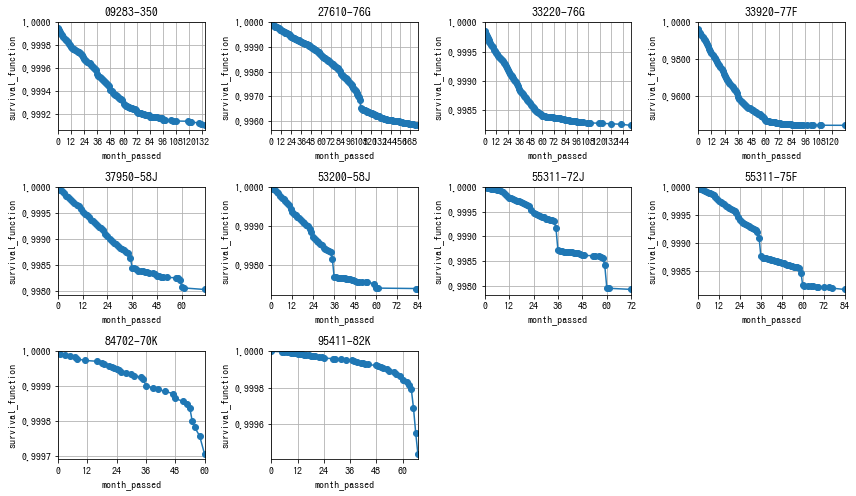

In [209]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(12,7))
for i,part in enumerate(survival_table.causal_part.unique()):
    ax = fig.add_subplot(3,4,i+1)
    df_tmp = survival_table[survival_table.causal_part==part].set_index("month_passed")
    df_tmp["survival_function"].plot(ax=ax, style="o-")
    ax.set(ylabel="survival_function", xlabel="month_passed",
          title=part, ylim=[None,1])
    max_x = df_tmp.index.max()
    ax.set_xticks(np.arange(0, max_x+1, 12))
    ax.grid()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.04f'))

plt.tight_layout()

- 極端な減少があるもの("53311-75F"など)は、ワイブル分布などのパラメトリックな方法ではモデリングが難しいと思われる。ノンパラメトリックまたはセミパラメトリックモデルによるモデリングを試みる。
- 急激な減少のないものについては、パラメトリックな方法も使用できるだろう。

- **60ヶ月以降は含めないで良い。**
    - **品番で、重要部品は60ヶ月、ほかは36ヶ月**
- **W_FIELD_CLAIM_DIV**

## 生存関数のモデリング

### ノンパラメトリックモデル

### パラメトリックモデル

### パラメトリックモデル

## 生存関数モデルによる故障数の予測